In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split as TTS,  GridSearchCV  
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as NB


import nltk
from nltk.corpus import stopwords, sentiwordnet, wordnet
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
lotr_train = pd.read_csv('lotr_train.csv')
lotr_test = pd.read_csv('lotr_test.csv')

imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]

## Character prediction
### Divide and conquer

In [3]:
# Creating a common label for the characters not of interest. 
# Aware that this will impact the model, unsure if it would be positive or negative


def common_label(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

lotr_train = common_label(lotr_train)
lotr_test = common_label(lotr_test)


def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

lotr_train_X, lotr_train_Y = x_y_split(lotr_train)
lotr_test_X, lotr_test_Y = x_y_split(lotr_test)

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

lotr_train_Y, names = char_2_num(lotr_train_Y)
lotr_test_Y = char_2_num(lotr_test_Y)[0]


['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [4]:
eval_methods = [ f1_score, precision_score, recall_score]

def naive_model(x_data, y_data):
    pred = np.random.randint(0, 12, size=len(x_data))
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred   

naive_predicitons = naive_model(lotr_test_X, lotr_test_Y)

              precision    recall  f1-score   support

           0       0.03      0.02      0.02        53
           1       0.00      0.00      0.00        14
           2       0.20      0.15      0.17        74
           3       0.03      0.01      0.02        76
           4       0.04      0.06      0.05        31
           5       0.06      0.06      0.06        32
           6       0.18      0.17      0.17        35
           7       0.16      0.16      0.16        44
           8       0.20      0.12      0.15        75
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        18
          11       0.02      0.03      0.02        36

    accuracy                           0.08       490
   macro avg       0.08      0.07      0.07       490
weighted avg       0.10      0.08      0.09       490

Accuracy  0.0816
f1_score 0.09
precision_score 0.1046
recall_score 0.0816


In [5]:

def optimize_model_parameters(X_train, y_train, model, param_grid, cv=5):
 
    rfc = model()

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_score)


    optimized = model(**best_params)
    optimized.fit(X_train, y_train)
    return optimized


param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [ 5, 10, 15],
    #'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Optimize parameters
optimized_rf = optimize_model_parameters(lotr_train_X, lotr_train_Y, RFC, param_grid)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 25}
Best Accuracy Score: 0.20745718050065878


In [6]:
def evaluate_model(x_data, y_data, model):

    pred = model.predict(x_data)
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred  

rfc_predictions = evaluate_model(lotr_test_X, lotr_test_Y, optimized_rf) 

              precision    recall  f1-score   support

           0       0.13      0.11      0.12        53
           1       0.00      0.00      0.00        14
           2       0.18      0.35      0.24        74
           3       0.32      0.45      0.37        76
           4       0.00      0.00      0.00        31
           5       0.04      0.03      0.03        32
           6       0.14      0.09      0.11        35
           7       0.08      0.11      0.10        44
           8       0.16      0.17      0.17        75
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00        36

    accuracy                           0.18       490
   macro avg       0.09      0.11      0.09       490
weighted avg       0.14      0.18      0.15       490

Accuracy  0.1796
f1_score 0.1508
precision_score 0.1355
recall_score 0.1796


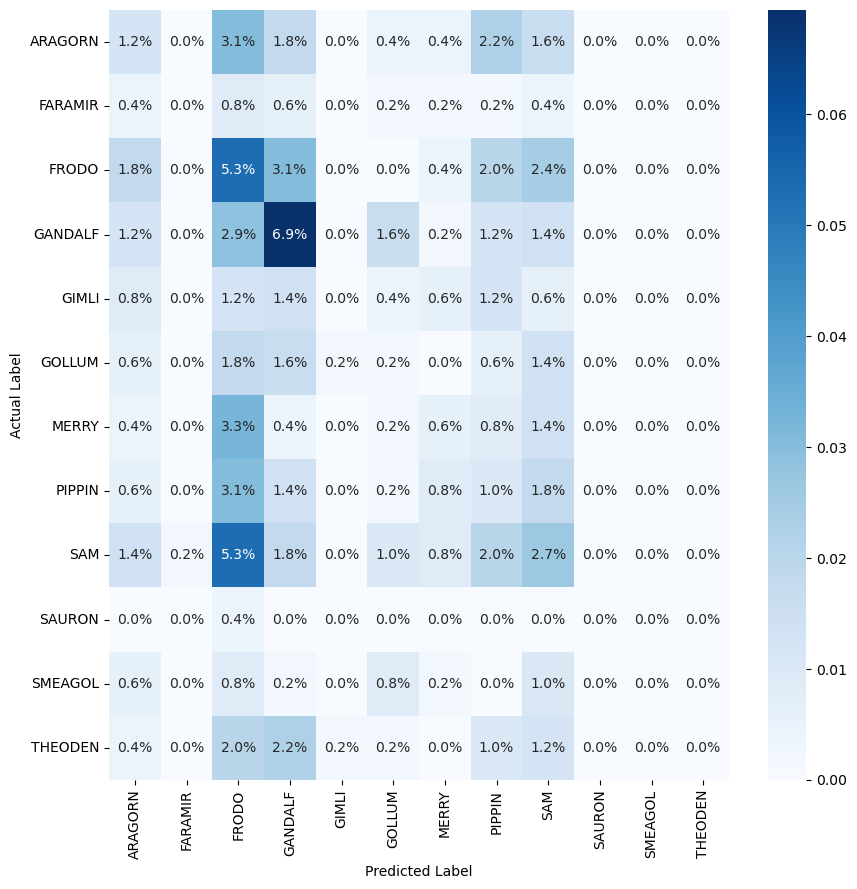

In [9]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

conf_matrix(lotr_test_Y, rfc_predictions)